## TODO:

1. Cite this:https://towardsdatascience.com/fitting-a-neural-network-using-randomized-optimization-in-python-71595de4ad2d`
4. Weight Evaluation's
5. Explain early stopping criteria
7. Add CV
9. Investigate high values of loss for GA
10. Investigate GA stuff for low performance
11. Investigate NN max_attempts usage

In [2]:
import mlrose_hiive as mlrose
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import to_categorical
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

## Dataset Preparation

In [3]:
df = pd.read_csv("data/winequality-red.csv", sep=';')
print(df.shape)

X = df[df.columns[:-1]]
y = df[df.columns[-1]]

encoded_Y = LabelEncoder().fit_transform(y)

y = to_categorical(encoded_Y)

X = (X - X.mean()) / X.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

(1599, 12)


## NN Training

In [5]:
models = {}

In [6]:
alg = 'random_hill_climb'
nn_model1 = mlrose.NeuralNetwork(
    hidden_nodes = [10, 10, 10, 10], 
    activation = 'relu',               
    algorithm = alg, 
    max_iters = 10000,
    bias = True,
    is_classifier = True,
    learning_rate = 0.1,
    early_stopping = True,
    max_attempts = 10,
    random_state = 1,
    restarts=2,
    curve=True
)
start = time.time()
models[alg] = nn_model1.fit(X_train, y_train)
print(time.time() - start)
y_train_pred = nn_model1.predict(X_train)
y_train_accuracy = accuracy_score(y_train, y_train_pred)
print('Training accuracy: ', y_train_accuracy)

y_test_pred = nn_model1.predict(X_test)
y_test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy: ', y_test_accuracy)

7.6569459438323975
Training accuracy:  0.5613760750586395
Test accuracy:  0.503125


(677, 2)


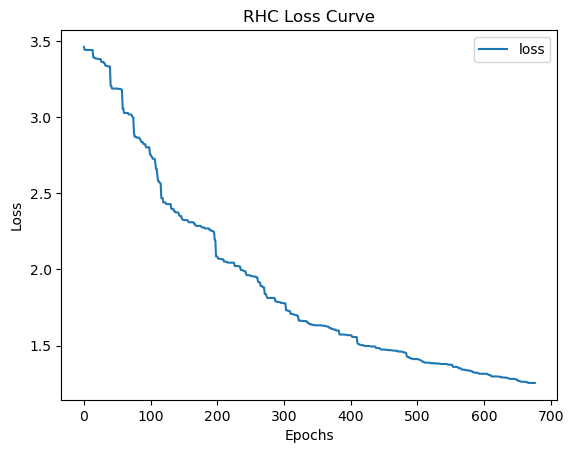

In [7]:
plot_df = pd.DataFrame()
plot_df.index = range(models[alg].fitness_curve.shape[0])
print(models[alg].fitness_curve.shape)
plot_df['loss'] = models[alg].fitness_curve.T[0]

plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Epochs', ylabel='Loss', title='RHC Loss Curve');
plt.savefig('rhc_loss_curve.png')

The value of the loss never increases when using this setup. RHC can only move upwards so the loss can never get worse. The rate of change in loss is pretty standard through initial exploration. Compared to other algs, this is different. Most improve much much more right at the beginning and then flatten out as it goes on. This still flattens out but much slower. 

With a low learning rate, the hill would not be climbed fast enough even with a high number of iterations. The best performance that was seen with a learning rate .001 was 37 and 37 and took 48 seconds. .1 has provided consistent early stopping with accuracy of .56 on test and .59 on training and took 24 seconds. With a learning rate of .9, only 90 iterations were completed and accuracy was .48 and .51 in 4.4 seconds. .1 seems to be the best balance to actually gain some convergence in decent amount of time.

With 2 max_attempts, no convergence took place. This is the max number of neighbors that will be explored before moving to a giving up. We were predicting near baseline for the test and training set with 2 max attempts (.38) .2 seconds. Same behavior at 5 max attempts and took 1.3. 10 had a performance of .55 and .57 and took 24 seconds. With 15, there was overfitting from .58 and 60 and took 51. For 20 Max attempts, it took 72 seconds and was 52 and 61 for performance. This is where overfitting began.

Adjusting the restarts seems to have very little impact on performance. It is not actually needing to restart because it is early stopping due to a decrease in performance gain. Going from 1 to 10 restarts did not improve overall performance meaning that we are likely not being hung up on any local minima.

In [8]:
alg = 'simulated_annealing'

nn_model1 = mlrose.NeuralNetwork(    
    hidden_nodes = [10, 10, 10, 10], 
    activation = 'relu',               
    algorithm = alg, 
    max_iters = 10000,
    bias = True, 
    is_classifier = True, 
    learning_rate = 0.1,
    early_stopping = True,
    max_attempts = 10,
    random_state = 1, 
    curve=True
)

start = time.time()
models[alg] = nn_model1.fit(X_train, y_train)
print(time.time() - start)
y_train_pred = nn_model1.predict(X_train)
y_train_accuracy = accuracy_score(y_train, y_train_pred)
print('Training accuracy: ', y_train_accuracy)

y_test_pred = nn_model1.predict(X_test)
y_test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy: ', y_test_accuracy)

28.45881962776184
Training accuracy:  0.5801407349491791
Test accuracy:  0.596875


(10000, 2)
9934


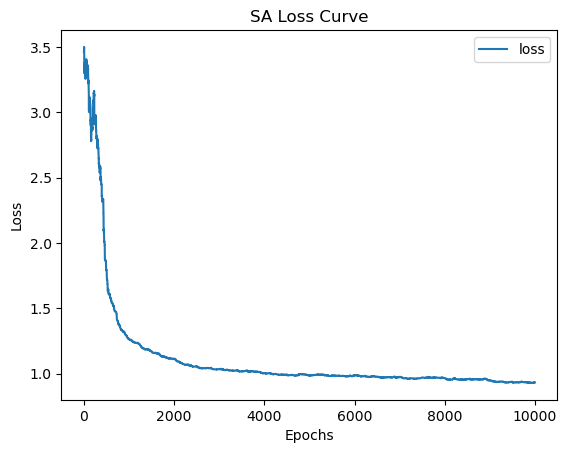

In [9]:
plot_df = pd.DataFrame()
plot_df.index = range(models[alg].fitness_curve.shape[0])

print(models[alg].fitness_curve.shape)
print(np.argmin( models[alg].fitness_curve.T[0]))
plot_df['loss'] = models[alg].fitness_curve.T[0]

plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Epochs', ylabel='Loss', title='SA Loss Curve');
plt.savefig('sa_loss_curve.png')

First, SA is not as smooth as RHC. There are actually large gains in loss early on and then small gains later down the road. This is due to temp. There was a very sharp increase in performance on the early stages of this. 

Baseline with a learning rate of .1, 10 max attempts, and max_iters of 10000 lead to a performance of 57 and 61 in 31 seconds. 

Decreasing max_attemppts to 1 had 111 iterations and had a baseline performance. It took .41 seconds. 
Increasing to 5 lead to 45 and 45 in 2.9 seconds. 
10 was baseline.
15 was same performance as baseline and took 31 seconds as well.
20 was the exact same as well. 

Learning rate of .01 had a performance of .46 and .50. It took 34 seconds
.1 was baseline.
.9 was 42 and 45 and took 2 seconds. The chart was much more wild on its way down towards the min loss. 

Decreasing number of iterations prevented any generalization and showed bad performance on all possible parameters. 

In [15]:
alg = 'genetic_alg'

nn_model1 = mlrose.NeuralNetwork(    
    hidden_nodes = [10, 10, 10, 10], 
    activation = 'relu',               
    algorithm = alg, 
    max_iters = 10000,
    bias = True, 
    is_classifier = True, 
    learning_rate = 0.1,
    early_stopping = True,
    max_attempts = 200,
    random_state = 1,
    mutation_prob=.01,
    pop_size=20,
    curve=True
)
start = time.time()
models[alg] = nn_model1.fit(X_train, y_train)
print(time.time() - start)
y_train_pred = nn_model1.predict(X_train)
y_train_accuracy = accuracy_score(y_train, y_train_pred)
print('Training accuracy: ', y_train_accuracy)

y_test_pred = nn_model1.predict(X_test)
y_test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy: ', y_test_accuracy)

21.42818260192871
Training accuracy:  0.6082877247849883
Test accuracy:  0.596875


(509, 2)


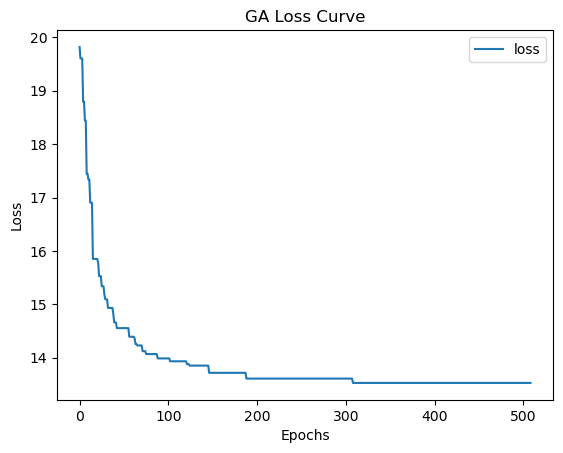

In [16]:
plot_df = pd.DataFrame()
plot_df.index = range(models[alg].fitness_curve.shape[0])

print(models[alg].fitness_curve.shape)
plot_df['loss'] = models[alg].fitness_curve.T[0]

plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Epochs', ylabel='Loss', title='GA Loss Curve');
plt.savefig('ga_loss_curve.png')

Starting with 5 pop size: .4 and .4 and took .2
10 pop size: .4 and .5 with .4
25 : .5 and .53 in 2.3. There is also a stair step look showing up at this point.
100: .05 and .05 in 15 seconds
200: 0 and 0 in 20 seconds

Moving max attempts up:
10 baseline
100 14 seconds and 53 57
200 with normal is same as above.
200 pop size with 200 max attempts(one off experiment to see if that improve performance) : 122 seconds and 0 and 0 again. 


.1 learning rate is baseline
.9 is same as .1
.01 is same so learning rate does not have impact (of course)

.001: Less actual gain on loss. Took 45 seconds. Smooth with a few large negative jumps. 55 and 62
.01: Much smoother and consistent descent to the bottom. No positive jumps and a steep decline on the start. 6 and 63 in 45 seconds
.1 mutation rate is default
.2 : Much faster decrease in initial loss but then much less improvement near the bottom. A decay would be good on this. 18 seconds and .48 and 53
.5 : 12 seconds, 1 huge jump down, 20 and 17.

In [12]:
alg = 'gradient_descent'

nn_model1 = mlrose.NeuralNetwork(    
    hidden_nodes = [10, 10, 10, 10], 
    activation = 'relu',               
    algorithm = alg, 
    max_iters = 10000,
    bias = True, 
    is_classifier = True, 
    learning_rate = 0.0001,
    early_stopping = True,
    max_attempts = 10,
    random_state = 1, 
    curve=True
)
start = time.time()
models[alg] = nn_model1.fit(X_train, y_train)
print(time.time() - start)
y_train_pred = nn_model1.predict(X_train)
y_train_accuracy = accuracy_score(y_train, y_train_pred)
print('Training accuracy: ', y_train_accuracy)

y_test_pred = nn_model1.predict(X_test)
y_test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy: ', y_test_accuracy)

7.843115329742432
Training accuracy:  0.673182173573104
Test accuracy:  0.578125


(1888,)


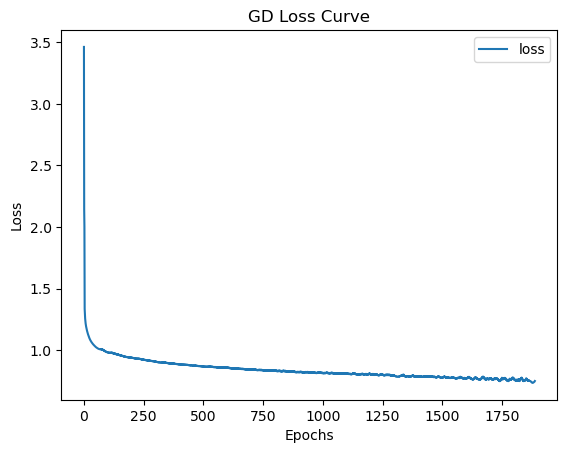

In [13]:
plot_df = pd.DataFrame()
plot_df.index = range(models[alg].fitness_curve.shape[0])

print(models[alg].fitness_curve.shape)
plot_df['loss'] = -models[alg].fitness_curve
# plot_df['val_loss'] = results.history['val_loss']

plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Epochs', ylabel='Loss', title='GD Loss Curve');
plt.savefig('gd_loss_curve.png')

Overfitting occuring at baseline of .0001 learning rate and max_attempts of 10. 53 and 71 in 12 seconds. 

only adjustment to be made is the learning rate.
.001 lead to baseline accuracy with a huge decrease in loss immediately. 43 seconds
.00001 lead to 68 and 52 in 45 seconds

In [14]:
models

{'random_hill_climb': NeuralNetwork(curve=True, early_stopping=True, hidden_nodes=[10, 10, 10, 10],
               max_iters=10000, random_state=1, restarts=2),
 'simulated_annealing': NeuralNetwork(algorithm='simulated_annealing', curve=True, early_stopping=True,
               hidden_nodes=[10, 10, 10, 10], max_iters=10000, random_state=1),
 'genetic_alg': NeuralNetwork(algorithm='genetic_alg', curve=True, early_stopping=True,
               hidden_nodes=[10, 10, 10, 10], max_attempts=200, max_iters=10000,
               mutation_prob=0.01, pop_size=2, random_state=1),
 'gradient_descent': NeuralNetwork(algorithm='gradient_descent', curve=True, early_stopping=True,
               hidden_nodes=[10, 10, 10, 10], learning_rate=0.0001,
               max_iters=10000, random_state=1)}

In [34]:
df = pd.DataFrame(index=range(1000))

In [38]:
models['gradient_descent'].fitness_curve

array([-3.46121779, -2.14472874, -2.00242844, ..., -0.745489  ,
       -0.74908183, -0.75175882])

In [46]:
df['rhc'] = pd.Series(models['random_hill_climb'].fitness_curve.T[0])
df['sa'] =  pd.Series(models['simulated_annealing'].fitness_curve.T[0])
df['ga'] =  pd.Series(models['genetic_alg'].fitness_curve.T[0])
df['gd'] =  pd.Series(-models['gradient_descent'].fitness_curve)

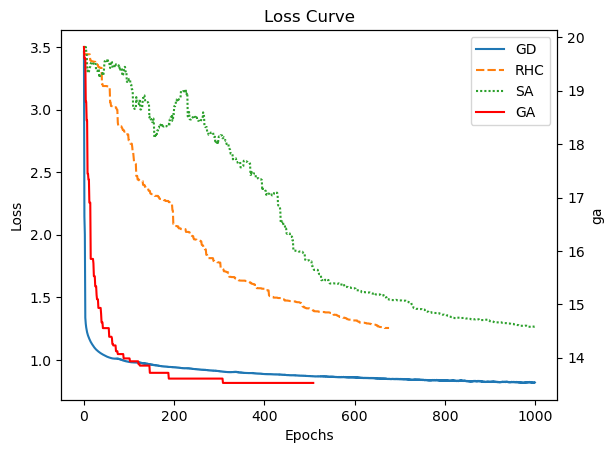

In [68]:
plot = sb.lineplot(data=df.drop('ga', axis=1), legend=False)
ax2 = plot.twinx()
sb.lineplot(x=range(1000), y=df['ga'], ax=ax2, color='red', legend=False)
plot.set(xlabel='Epochs', ylabel='Loss', title='Loss Curve');
plot.legend(handles=plot.lines + ax2.lines, labels=["GD","RHC","SA", "GA"])
plt.savefig('loss_curve.png')